# Responsible Machine Learning Group Project 

### Kaggle Twitter Sentiment Extraction 
Group 6: Chuxin Piao, Xiao Wang, Hanqiu Yang, Wanyu Zhong

Reference: https://www.kaggle.com/nkoprowicz/a-simple-solution-using-only-word-counts

### License 

Copyright 2020 Patrick Hall (jphall@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### Load Packages

In [1]:
#pip install afinn

In [2]:
#pip install vaderSentiment

In [3]:
#pip install shap

In [4]:
#nltk packages
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation

#Pandas
import pandas as pd
import numpy as np
#enable display of all columns in notebook
pd.options.display.max_columns = 999 
np.random.seed(12345)

#re
import re

#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import r2_score

#string
import string


#sentiment packages
from textblob import TextBlob

#Used in creating ngrams
import math

#xgboost
import shap
import xgboost as xgb

#plt
import matplotlib.pyplot as plt
#enables display of plots in notebook
%matplotlib inline 

#stats
from scipy import stats

### Load Dataset

In [111]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

#---Kaggle load dataset path---
# train = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/train.csv")
# test = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/test.csv")
# sample_submission = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/sample_submission.csv")

### Check Missing Values

In [112]:
train[train['text'].isna()]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


Since there is only one row, we decided to drop it

In [113]:
train.drop(314, inplace = True)
train = train.reset_index(drop = True)

In [114]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


- textID - unique ID for each piece of text
- text - the text of the tweet
- sentiment - the general sentiment of the tweet
- selected_text - [train only] the text that supports the tweet's sentiment

In [115]:
#Prepare column names for xgboost
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

In [116]:
#Define a function to calculate jaccard score, which is a quantitive method to meseaure the closeness of two strings

def jaccard(str1,str2):
    a=str1.lower().split(" ")
    b=str2.lower().split(" ")
    c=set(a)&set(b)
    prop=len(c)/(len(a)+len(b)-len(c))
    return(prop)

In [117]:
neutral_train = train[train['sentiment'] == 'neutral']
train = train[train['sentiment'] != 'neutral']
neutral_test = test[test['sentiment'] == 'neutral']
test = test[test['sentiment'] != 'neutral']

In [118]:
train.head()

,textID,text,selected_text,sentiment
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive


In [119]:
# Create jaccard score for texts in train set with neutral sentiment
neutral_train.apply(lambda x: jaccard(x['text'], x['selected_text']), axis = 1).mean()

0.8651236715977233

The average jaccard score for texts and selected text in train set with neutral sentiment is close to 1, thus we use the full original text as selected text 

### Remove URL from text

In [17]:
def remove_url(text):
    url_pattern = re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", flags=re.UNICODE)
    return url_pattern.sub(r'', text)

In [18]:
train['text']=train['text'].apply(lambda x:remove_url(x))
test['text']=test['text'].apply(lambda x:remove_url(x))

### Create features

Create part of general features without using n-grams to save time. Then create other features for texts after creating train subsets and test subsets with n-grams.

- Text_n_words: Number of words in original text
- Text_n_str: Number of strings in original text
- Text_n_uq_chars: Number of unique characters in original text
- Sel_text_n_words: Number of words in ngram
- Prop_sel_text_len: Length of ngram / Length of original texts
- Sentiment: positive/ negative/ neutral
- sel_text_sent_blob:  Sentiment score of ngram based on Blob sentiment analysis package
- text_sent_blob: Entiment score of original text based on Blob sentiment analysis package
- Dif_text_sent_blob: sentiment score difference between ngram and original text based on Blob sentiment analysis package
- Sel_text_n_str: Number of strings of texts in ngram
- Prop_sel_text_n_str: Number of strings of ngram / Number of strings of texts
- Sel_text_n_uq_words: Number of unique words of ngram
- text_n_uq_words: Number of unique words in original text
- Prop_sel_text_n_uq_words: Number of unique words in ngram / Number of unique words in the original text
- sel_text_n_uq_chars: Number of unique characters in ngram
- Prop_sel_text_n_uq_chars: Number of unique characters in ngram / Number of unique characters in original text
- text_n_prepositions: Number of prepositions in original text
- sel_text_n_prepositions: Number of prepositions in ngram
- Prop_sel_text_n_prepositions: Number of prepositions in ngram / Number of prepositions in original text

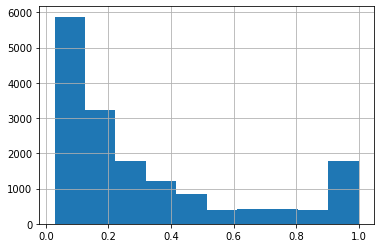

In [19]:
#Check the distribution of proportion of selected_text versus text_n_words in train set
train['text_n_words'] = train['text'].apply(str).apply(lambda x: len(x.split(" ")))
train['sel_text_n_words'] = train['selected_text'].apply(str).apply(lambda x: len(x.split(" ")))
train['prop_sel_text_len'] = train['sel_text_n_words']/train['text_n_words']
train['prop_sel_text_len'].hist()

In [130]:
#Number of string in text
def find_str(text):
  result = re.split('[!?,.]',text)
  count = len(result)
  return count

#List of prepositions
prep = ['about', 'below', 'excepting', 'off', 'toward', 'above', 'beneath', 'on', 'under', 'across', 'from','onto',
'underneath', 'after','between', 'in', 'out', 'until', 'against', 'beyond' , 'outside', 'up' , 'along', 'but', 'inside','over',
'upon', 'among','by','past', 'around', 'concerning', 'regarding', 'with', 'at', 'despite','into', 'since', 'within',
'down', 'like', 'through','without', 'before', 'during', 'near', 'throughout', 'behind', 'except', 'of', 'to', 'for']

#return the number of prepositions in the sentence
def preposition(sentence):
  words = sentence.split()
  prep_num = 0
  for x in prep:
      prep_num += words.count(x)
  return prep_num

In [21]:
#Create features for train set
train['text_sent_blob'] = train['text'].apply(str).apply(lambda x: TextBlob(x.lower()).sentiment.polarity)#Blob sentiment score
train['text_n_str'] = train['text'].apply(str).apply(lambda x: find_str(x.lower()))#Number of string in text
train['text_n_uq_words'] = train['text'].apply(str).apply(lambda x: len(np.unique(x.strip().split())))#Number of unique words
train['text_n_uq_chars'] = train['text'].apply(str).apply(lambda x: len(np.unique(list(x.replace(" ", "")))))#Number of unique characters
train['text_n_prepositions'] = train['text'].apply(str).apply(lambda x: preposition(x.lower()))#Number of prepositions

In [22]:
train.head()

,textID,text,selected_text,sentiment,text_n_words,sel_text_n_words,prop_sel_text_len,text_sent_blob,text_n_str,text_n_uq_words,text_n_uq_chars,text_n_prepositions
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,11,2,0.181818,-0.976562,4,10,19,1
2,088c60f138,my boss is bullying me...,bullying me,negative,5,2,0.400000,0.000000,4,5,12,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,6,3,0.500000,0.000000,2,5,13,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,15,3,0.200000,0.000000,2,14,23,2
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,14,1,0.071429,0.300000,1,14,20,1


In [23]:
#Create features for test set
test['text_n_words'] = test['text'].apply(str).apply(lambda x: len(x.split(" "))) #Number of words in original text
test['text_sent_blob'] = test['text'].apply(str).apply(lambda x: TextBlob(x.lower()).sentiment.polarity)#Blob sentiment score
test['text_n_str'] = test['text'].apply(str).apply(lambda x: find_str(x.lower()))#Number of string in text
test['text_n_uq_words'] = test['text'].apply(str).apply(lambda x: len(np.unique(x.strip().split())))#Number of unique words
test['text_n_uq_chars'] = test['text'].apply(str).apply(lambda x: len(np.unique(list(x.replace(" ", "")))))#Number of unique characters
test['text_n_prepositions'] = test['text'].apply(str).apply(lambda x: preposition(x.lower()))#Number of prepositions

In [24]:
test.head()

,textID,text,sentiment,text_n_words,text_sent_blob,text_n_str,text_n_uq_words,text_n_uq_chars,text_n_prepositions
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,18,0.1625,3,15,29,1
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,13,0.0000,4,13,20,1
3,01082688c6,happy bday!,positive,3,1.0000,2,2,7,0
4,33987a8ee5,- I like it!!,positive,6,0.0000,3,4,8,1
5,726e501993,that`s great!! weee!! visitors!,positive,5,1.0000,6,4,13,0


In [25]:
#Create ngrams for a line
def create_ngrams(line):
  words = line['text'].split()
  # subsets = [words[i:j+1] for i in range(len(words)) for j in range(i,len(words))] #Create subset for whole train set
  subsets = [words[i:j+1] for i in range(len(words)) for j in range(i,int(math.ceil(len(words)/2)))] #Create subset for only the rows with subsetsLen(ngrams)/Len(original text) <= 0.5
  return subsets

In [26]:
#Create ngrams subsets for train set
train_subsets = pd.DataFrame()
train_temp = pd.DataFrame()
for i in range(len(train)):
  ngrams_lines = create_ngrams(train.iloc[i])
  train_temp = pd.DataFrame([train.iloc[i]]*(len(ngrams_lines)))
  train_temp['ngram'] = list(map(lambda x: " ".join(words for words in x),ngrams_lines))#Combine the new lines with their ngrams
  train_subsets = train_subsets.append(train_temp,ignore_index=True)#Append new lines with ngrams to train_subsets

CPU times: user 15min 28s, sys: 2min 34s, total: 18min 3s
Wall time: 18min 5s


In [27]:
train_temp = train
train_temp['ngram'] = train_temp['text']
train_subsets = train_subsets.append(train_temp,ignore_index=True) #Append original train set to get subsetsLen(ngrams)/Len(original text) = 1

In [28]:
#Update the two columns created before
train_subsets['sel_text_n_words'] = train_subsets['ngram'].apply(str).apply(lambda x: len(x.split(" ")))
train_subsets['prop_sel_text_len'] = train_subsets['sel_text_n_words']/train_subsets['text_n_words']

In [29]:
len(train_subsets)

554364

In [30]:
train_subsets.head()

,textID,text,selected_text,sentiment,text_n_words,sel_text_n_words,prop_sel_text_len,text_sent_blob,text_n_str,text_n_uq_words,text_n_uq_chars,text_n_prepositions,ngram
0,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,11,1,0.090909,-0.976562,4,10,19,1,Sooo
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,11,2,0.181818,-0.976562,4,10,19,1,Sooo SAD
2,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,11,3,0.272727,-0.976562,4,10,19,1,Sooo SAD I
3,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,11,4,0.363636,-0.976562,4,10,19,1,Sooo SAD I will
4,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,11,5,0.454545,-0.976562,4,10,19,1,Sooo SAD I will miss


In [32]:
test_subsets = pd.DataFrame()
test_temp = pd.DataFrame()
for i in range(len(test)):
  ngrams_lines = create_ngrams(test.iloc[i])
  test_temp = pd.DataFrame([test.iloc[i]]*(len(ngrams_lines)))
  test_temp['ngram'] = list(map(lambda x: " ".join(words for words in x),ngrams_lines))#Combine the new lines with their ngrams
  test_subsets = test_subsets.append(test_temp,ignore_index=True)#Append new lines with ngrams to test_subsets

CPU times: user 16.5 s, sys: 804 ms, total: 17.3 s
Wall time: 17.3 s


In [33]:
test_temp = test
test_temp['ngram'] = test_temp['text']
test_subsets = test_subsets.append(test_temp,ignore_index=True) #Append original test set to get subsetsLen(ngrams)/Len(original text) = 1

In [34]:
#Update the two columns created before
test_subsets['sel_text_n_words'] = test_subsets['ngram'].apply(str).apply(lambda x: len(x.split(" ")))
test_subsets['prop_sel_text_len'] = test_subsets['sel_text_n_words']/test_subsets['text_n_words']

In [35]:
len(test_subsets)

68593

In [36]:
test_subsets.head()

,textID,text,sentiment,text_n_words,text_sent_blob,text_n_str,text_n_uq_words,text_n_uq_chars,text_n_prepositions,ngram,sel_text_n_words,prop_sel_text_len
0,96d74cb729,Shanghai is also really exciting (precisely -...,positive,18,0.1625,3,15,29,1,Shanghai,1,0.055556
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,18,0.1625,3,15,29,1,Shanghai is,2,0.111111
2,96d74cb729,Shanghai is also really exciting (precisely -...,positive,18,0.1625,3,15,29,1,Shanghai is also,3,0.166667
3,96d74cb729,Shanghai is also really exciting (precisely -...,positive,18,0.1625,3,15,29,1,Shanghai is also really,4,0.222222
4,96d74cb729,Shanghai is also really exciting (precisely -...,positive,18,0.1625,3,15,29,1,Shanghai is also really exciting,5,0.277778


In [37]:
test_subsets.tail()

,textID,text,sentiment,text_n_words,text_sent_blob,text_n_str,text_n_uq_words,text_n_uq_chars,text_n_prepositions,ngram,sel_text_n_words,prop_sel_text_len
68588,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative,16,-0.5200,2,13,19,3,"its at 3 am, im very tired but i can`t sleep ...",16,1.0
68589,416863ce47,All alone in this old house again. Thanks for...,positive,27,0.0850,5,25,27,2,All alone in this old house again. Thanks for...,27,1.0
68590,6332da480c,I know what you mean. My little dog is sinkin...,negative,19,-0.1000,5,18,23,2,I know what you mean. My little dog is sinkin...,19,1.0
68591,df1baec676,_sutra what is your next youtube video gonna b...,positive,14,0.3125,3,13,22,0,_sutra what is your next youtube video gonna b...,14,1.0
68592,469e15c5a8,- omgssh ang cute ng bby.!,positive,9,0.6250,3,6,16,0,- omgssh ang cute ng bby.!,9,1.0


In [38]:
#Jaccard score
train_subsets['jaccard'] = train_subsets.apply(lambda x: jaccard(x['ngram'], x['selected_text']), axis = 1) # Create jaccard score for each row
#Blob score
train_subsets['sel_text_sent_blob'] = train_subsets['ngram'].apply(str).apply(lambda x: TextBlob(x.lower()).sentiment.polarity)
train_subsets['dif_text_sent_blob'] = train_subsets['text_sent_blob'] - train_subsets['sel_text_sent_blob']
#Proportion of number of string of ngrams
train_subsets['sel_text_n_str'] = train_subsets['ngram'].apply(str).apply(lambda x: find_str(x.lower()))
train_subsets['prop_sel_text_n_str'] = train_subsets['sel_text_n_str'] / train_subsets['text_n_str']
#Number of unique words of ngrams
train_subsets['sel_text_n_uq_words'] = train_subsets['ngram'].apply(str).apply(lambda x: len(np.unique(x.strip().split())))
train_subsets['prop_sel_text_n_uq_words'] =  train_subsets['sel_text_n_uq_words']/train_subsets['text_n_uq_words']
#Number of unique characters of ngrams
train_subsets['sel_text_n_uq_chars'] = train_subsets['ngram'].apply(str).apply(lambda x: len(np.unique(list(x.replace(" ", "")))))
train_subsets['prop_sel_text_n_uq_chars'] = train_subsets['sel_text_n_uq_chars']/train_subsets['text_n_uq_chars'] 
#Number of prepositions
train_subsets['sel_text_n_prepositions'] = train_subsets['ngram'].apply(str).apply(lambda x: preposition(x.lower()))
train_subsets['prop_sel_text_n_prepositions'] = train_subsets['sel_text_n_prepositions']/train_subsets['text_n_prepositions']

CPU times: user 1min 30s, sys: 579 ms, total: 1min 31s
Wall time: 1min 31s


In [39]:
train_subsets.head()

,textID,text,selected_text,sentiment,text_n_words,sel_text_n_words,prop_sel_text_len,text_sent_blob,text_n_str,text_n_uq_words,text_n_uq_chars,text_n_prepositions,ngram,jaccard,sel_text_sent_blob,dif_text_sent_blob,sel_text_n_str,prop_sel_text_n_str,sel_text_n_uq_words,prop_sel_text_n_uq_words,sel_text_n_uq_chars,prop_sel_text_n_uq_chars,sel_text_n_prepositions,prop_sel_text_n_prepositions
0,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,11,1,0.090909,-0.976562,4,10,19,1,Sooo,0.500000,0.0,-0.976562,1,0.25,1,0.1,2,0.105263,0,0.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,11,2,0.181818,-0.976562,4,10,19,1,Sooo SAD,1.000000,-0.5,-0.476562,1,0.25,2,0.2,4,0.210526,0,0.0
2,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,11,3,0.272727,-0.976562,4,10,19,1,Sooo SAD I,0.666667,-0.5,-0.476562,1,0.25,3,0.3,5,0.263158,0,0.0
3,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,11,4,0.363636,-0.976562,4,10,19,1,Sooo SAD I will,0.500000,-0.5,-0.476562,1,0.25,4,0.4,8,0.421053,0,0.0
4,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,11,5,0.454545,-0.976562,4,10,19,1,Sooo SAD I will miss,0.400000,-0.5,-0.476562,1,0.25,5,0.5,10,0.526316,0,0.0


In [40]:
#Blob score
test_subsets['sel_text_sent_blob'] = test_subsets['ngram'].apply(str).apply(lambda x: TextBlob(x.lower()).sentiment.polarity)
test_subsets['dif_text_sent_blob'] = test_subsets['text_sent_blob'] - test_subsets['sel_text_sent_blob']
#Proportion of number of string of ngrams
test_subsets['sel_text_n_str'] = test_subsets['ngram'].apply(str).apply(lambda x: find_str(x.lower()))
test_subsets['prop_sel_text_n_str'] = test_subsets['sel_text_n_str'] / test_subsets['text_n_str']
#Number of unique words of ngrams
test_subsets['sel_text_n_uq_words'] = test_subsets['ngram'].apply(str).apply(lambda x: len(np.unique(x.strip().split())))
test_subsets['prop_sel_text_n_uq_words'] = test_subsets['sel_text_n_uq_words']/test_subsets['text_n_uq_words'] 
#Number of unique characters of ngrams
test_subsets['sel_text_n_uq_chars'] = test_subsets['ngram'].apply(str).apply(lambda x: len(np.unique(list(x.replace(" ", "")))))
test_subsets['prop_sel_text_n_uq_chars'] = test_subsets['sel_text_n_uq_chars']/test_subsets['text_n_uq_chars']
#Number of prepositions
test_subsets['sel_text_n_prepositions'] = test_subsets['ngram'].apply(str).apply(lambda x: preposition(x.lower()))
test_subsets['prop_sel_text_n_prepositions'] = test_subsets['sel_text_n_prepositions']/test_subsets['text_n_prepositions']

CPU times: user 10.8 s, sys: 105 ms, total: 10.9 s
Wall time: 11 s


In [41]:
test_subsets.head()

,textID,text,sentiment,text_n_words,text_sent_blob,text_n_str,text_n_uq_words,text_n_uq_chars,text_n_prepositions,ngram,sel_text_n_words,prop_sel_text_len,sel_text_sent_blob,dif_text_sent_blob,sel_text_n_str,prop_sel_text_n_str,sel_text_n_uq_words,prop_sel_text_n_uq_words,sel_text_n_uq_chars,prop_sel_text_n_uq_chars,sel_text_n_prepositions,prop_sel_text_n_prepositions
0,96d74cb729,Shanghai is also really exciting (precisely -...,positive,18,0.1625,3,15,29,1,Shanghai,1,0.055556,0.0,0.1625,1,0.333333,1,0.066667,6,0.206897,0,0.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,18,0.1625,3,15,29,1,Shanghai is,2,0.111111,0.0,0.1625,1,0.333333,2,0.133333,7,0.241379,0,0.0
2,96d74cb729,Shanghai is also really exciting (precisely -...,positive,18,0.1625,3,15,29,1,Shanghai is also,3,0.166667,0.0,0.1625,1,0.333333,3,0.200000,9,0.310345,0,0.0
3,96d74cb729,Shanghai is also really exciting (precisely -...,positive,18,0.1625,3,15,29,1,Shanghai is also really,4,0.222222,0.2,-0.0375,1,0.333333,4,0.266667,12,0.413793,0,0.0
4,96d74cb729,Shanghai is also really exciting (precisely -...,positive,18,0.1625,3,15,29,1,Shanghai is also really exciting,5,0.277778,0.3,-0.1375,1,0.333333,5,0.333333,15,0.517241,0,0.0


### Xgboost

- We will run XgBoost model separately for positive sentiment rows and negative sentiment rows
- For neutral sentiment rows we will use original text as selected text as mentioned above

In [44]:
#separate positive and negative train and test dataset

train_subsets_pos =  train_subsets[train_subsets['sentiment'] == 'positive']
test_subsets_pos =  test_subsets[test_subsets['sentiment'] == 'positive']

train_subsets_neg =  train_subsets[train_subsets['sentiment'] == 'negative']
test_subsets_neg =  test_subsets[test_subsets['sentiment'] == 'negative']

In [45]:
# Add ID column to all the datasets

train_subsets_pos['ID'] = train_subsets_pos.index + 1
test_subsets_pos['ID'] = test_subsets_pos.index + 1
train_subsets_neg['ID'] = train_subsets_neg.index + 1
test_subsets_neg['ID'] = test_subsets_neg.index + 1


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [46]:
#Convert sentiment category to numerical values

def score_to_numeric(x):
    if x=='negative':
        return 0
    if x=='positive':
        return 1

In [47]:
#Convert sentiment category to numerical values
train_subsets_pos['sentiment'] = train_subsets_pos['sentiment'].apply(score_to_numeric)
test_subsets_pos['sentiment'] = test_subsets_pos['sentiment'].apply(score_to_numeric)

train_subsets_neg['sentiment'] = train_subsets_neg['sentiment'].apply(score_to_numeric)
test_subsets_neg['sentiment'] = test_subsets_neg['sentiment'].apply(score_to_numeric)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [48]:
#Define our target column and X variables

y = 'jaccard'
X = [name for name in train_subsets.columns if name not in [y, 'ID', 'textID','text', 'selected_text','ngram']]
print('y =', y)
print('X =', X)

y = jaccard
X = ['sentiment', 'text_n_words', 'sel_text_n_words', 'prop_sel_text_len', 'text_sent_blob', 'text_n_str', 'text_n_uq_words', 'text_n_uq_chars', 'text_n_prepositions', 'sel_text_sent_blob', 'dif_text_sent_blob', 'sel_text_n_str', 'prop_sel_text_n_str', 'sel_text_n_uq_words', 'prop_sel_text_n_uq_words', 'sel_text_n_uq_chars', 'prop_sel_text_n_uq_chars', 'sel_text_n_prepositions', 'prop_sel_text_n_prepositions']


In [49]:
train_subsets_pos[X + [y]].describe()

,sentiment,text_n_words,sel_text_n_words,prop_sel_text_len,text_sent_blob,text_n_str,text_n_uq_words,text_n_uq_chars,text_n_prepositions,sel_text_sent_blob,dif_text_sent_blob,sel_text_n_str,prop_sel_text_n_str,sel_text_n_uq_words,prop_sel_text_n_uq_words,sel_text_n_uq_chars,prop_sel_text_n_uq_chars,sel_text_n_prepositions,prop_sel_text_n_prepositions,jaccard
count,284206.0,284206.000000,284206.000000,284206.000000,284206.000000,284206.000000,284206.000000,284206.000000,284206.000000,284206.000000,284206.000000,284206.000000,284206.000000,284206.000000,284206.000000,284206.000000,284206.000000,284206.000000,242111.000000,284206.000000
mean,1.0,19.590322,4.170179,0.225170,0.369164,4.041871,17.376526,24.725298,2.026966,0.134972,0.234191,1.609628,0.491131,4.077370,0.247490,10.572578,0.432853,0.465634,0.235324,0.111485
std,0.0,6.231873,3.367268,0.182061,0.308534,2.499095,5.455683,4.874855,1.471640,0.280893,0.341673,1.166822,0.285994,3.138904,0.187890,5.701006,0.225846,0.711040,0.328406,0.194620
min,1.0,1.000000,1.000000,0.030303,-1.000000,1.000000,1.000000,3.000000,0.000000,-1.000000,-1.200000,1.000000,0.023256,1.000000,0.033333,1.000000,0.022727,0.000000,0.000000,0.000000
25%,1.0,15.000000,2.000000,0.100000,0.156250,2.000000,14.000000,22.000000,1.000000,0.000000,0.000000,1.000000,0.250000,2.000000,0.111111,6.000000,0.250000,0.000000,0.000000,0.000000
50%,1.0,20.000000,3.000000,0.185185,0.350000,4.000000,18.000000,25.000000,2.000000,0.000000,0.200000,1.000000,0.400000,3.000000,0.208333,10.000000,0.421053,0.000000,0.000000,0.000000
75%,1.0,24.000000,6.000000,0.300000,0.566667,5.000000,22.000000,28.000000,3.000000,0.200000,0.475000,2.000000,0.666667,6.000000,0.333333,15.000000,0.590909,1.000000,0.500000,0.166667
max,1.0,33.000000,33.000000,1.000000,1.000000,43.000000,30.000000,44.000000,8.000000,1.000000,1.462500,43.000000,1.000000,30.000000,1.000000,44.000000,1.000000,8.000000,1.000000,1.000000


In [50]:
train_subsets_neg[X + [y]].describe()

,sentiment,text_n_words,sel_text_n_words,prop_sel_text_len,text_sent_blob,text_n_str,text_n_uq_words,text_n_uq_chars,text_n_prepositions,sel_text_sent_blob,dif_text_sent_blob,sel_text_n_str,prop_sel_text_n_str,sel_text_n_uq_words,prop_sel_text_n_uq_words,sel_text_n_uq_chars,prop_sel_text_n_uq_chars,sel_text_n_prepositions,prop_sel_text_n_prepositions,jaccard
count,270158.0,270158.000000,270158.000000,270158.000000,270158.000000,270158.000000,270158.000000,270158.000000,270158.000000,270158.000000,270158.000000,270158.000000,270158.000000,270158.000000,270158.000000,270158.000000,270158.000000,270158.000000,235403.000000,270158.000000
mean,0.0,19.840778,4.234811,0.225836,-0.084221,3.963033,17.749761,24.143383,2.165474,-0.030748,-0.053473,1.557333,0.497244,4.141365,0.245525,10.426347,0.436147,0.496713,0.234403,0.112856
std,0.0,6.349236,3.398224,0.180672,0.327727,2.639446,5.539680,4.721958,1.529402,0.235975,0.318463,1.165866,0.292467,3.177795,0.185409,5.621196,0.226075,0.740786,0.323577,0.192087
min,0.0,1.000000,1.000000,0.026316,-1.000000,1.000000,1.000000,1.000000,0.000000,-1.000000,-1.500000,1.000000,0.013158,1.000000,0.033333,1.000000,0.021277,0.000000,0.000000,0.000000
25%,0.0,15.000000,2.000000,0.100000,-0.268750,2.000000,14.000000,21.000000,1.000000,0.000000,-0.204687,1.000000,0.250000,2.000000,0.111111,6.000000,0.250000,0.000000,0.000000,0.000000
50%,0.0,21.000000,3.000000,0.187500,0.000000,3.000000,19.000000,24.000000,2.000000,0.000000,0.000000,1.000000,0.500000,3.000000,0.208333,10.000000,0.423077,0.000000,0.000000,0.000000
75%,0.0,25.000000,6.000000,0.300000,0.066667,5.000000,22.000000,27.000000,3.000000,0.000000,0.068182,2.000000,0.666667,6.000000,0.333333,14.000000,0.600000,1.000000,0.500000,0.166667
max,0.0,38.000000,38.000000,1.000000,1.000000,76.000000,30.000000,47.000000,10.000000,1.000000,1.300000,76.000000,1.000000,30.000000,1.000000,47.000000,1.000000,10.000000,1.000000,1.000000


In [51]:
np.random.seed(12345) # set random seed for reproducibility
split_ratio = 0.7     # 70%/30% train/test split

# execute split_pos
split_pos = np.random.rand(len(train_subsets_pos)) < split_ratio
train_pos = train_subsets_pos[split_pos]
test_pos = train_subsets_pos[~split_pos]

# summarize split_pos
print('Train_pos data rows = %d, columns = %d' % (train_pos.shape[0], train_pos.shape[1]))
print('Test_pos data rows = %d, columns = %d' % (test_pos.shape[0], test_pos.shape[1]))

# execute split_neg
split_neg = np.random.rand(len(train_subsets_neg)) < split_ratio
train_neg = train_subsets_neg[split_neg]
test_neg = train_subsets_neg[~split_neg]

# summarize split_neg
print('Train_neg data rows = %d, columns = %d' % (train_neg.shape[0], train_neg.shape[1]))
print('Test_neg data rows = %d, columns = %d' % (test_neg.shape[0], test_neg.shape[1]))

Train_pos data rows = 199004, columns = 25
Test_pos data rows = 85202, columns = 25
Train_neg data rows = 189009, columns = 25
Test_neg data rows = 81149, columns = 25


In [52]:
#Create matrix for XgBoost model

dtrain_pos = xgb.DMatrix(train_pos[X], train_pos[y])
dtest_pos = xgb.DMatrix(test_pos[X], test_pos[y])
dtrain_neg = xgb.DMatrix(train_neg[X], train_neg[y])
dtest_neg = xgb.DMatrix(test_neg[X], test_neg[y])

In [53]:
#Positive dataset model training
base_y_pos = train_pos[y].mean()

# tuning parameters
params = {
    'objective': 'reg:linear', 
    'bagging_fraction': 0.8768575337571937,
    'colsample_bytree': 0.9933592930641432,
    'feature_fraction': 0.816825176108506,
    'gamma': 0.05587328363633812,
    'learning_rate': 0.19879098664834996,
    'max_depth': 6,
    'min_child_samples': 9,
    'num_leaves': 7,
    'reg_alpha': 0.11806338517600543,
    'reg_lambda': 0.23269341544465222,
    'subsample': 0.6,
    'base_score': base_y_pos,                   
    'seed': 12345                               
}


# watchlist is used for early stopping
watchlist_pos = [(dtrain_pos, 'train'), (dtest_pos, 'eval')]

# train model
xgb_model_pos = xgb.train(params,                   # set tuning parameters from above                   
                      dtrain_pos,                   # training data
                      1000,                     # maximum of 1000 iterations (trees)
                      evals=watchlist_pos,          # use watchlist for early stopping 
                      early_stopping_rounds=50, # stop after 50 iterations (trees) without increase in rmse 
                      verbose_eval=True)




[21:26:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:0.186395	eval-rmse:0.184303
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:0.180273	eval-rmse:0.178417
[2]	train-rmse:0.175952	eval-rmse:0.174304
[3]	train-rmse:0.172978	eval-rmse:0.171536
[4]	train-rmse:0.17085	eval-rmse:0.169573
[5]	train-rmse:0.169282	eval-rmse:0.168139
[6]	train-rmse:0.168133	eval-rmse:0.167138
[7]	train-rmse:0.167179	eval-rmse:0.166305
[8]	train-rmse:0.16642	eval-rmse:0.165701
[9]	train-rmse:0.165809	eval-rmse:0.165206
[10]	train-rmse:0.16534	eval-rmse:0.164833
[11]	train-rmse:0.164797	eval-rmse:0.164444
[12]	train-rmse:0.164407	eval-rmse:0.164172
[13]	train-rmse:0.163855	eval-rmse:0.163659
[14]	train-rmse:0.163601	eval-rmse:0.163478
[15]	train-rmse:0.163207	eval-rmse:0.16315
[16]	train-rmse:0.162957	eval-rmse:0.162962
[17]	tr

In [54]:
#Negative dataset model training
base_y_neg = train_neg[y].mean()

# tuning parameters
params = {
    'objective': 'reg:linear', 
    'bagging_fraction': 0.8768575337571937,
    'colsample_bytree': 0.9933592930641432,
    'feature_fraction': 0.816825176108506,
    'gamma': 0.05587328363633812,
    'learning_rate': 0.19879098664834996,
    'max_depth': 6,
    'min_child_samples': 9,
    'num_leaves': 7,
    'reg_alpha': 0.11806338517600543,
    'reg_lambda': 0.23269341544465222,
    'subsample': 0.6,
    'base_score': base_y_neg,                   
    'seed': 12345                               
}

# watchlist is used for early stopping
watchlist_neg = [(dtrain_neg, 'train'), (dtest_neg, 'eval')]

# train model
xgb_model_neg = xgb.train(params,                   # set tuning parameters from above                   
                      dtrain_neg,                   # training data
                      1000,                     # maximum of 1000 iterations (trees)
                      evals=watchlist_neg,          # use watchlist for early stopping 
                      early_stopping_rounds=50, # stop after 50 iterations (trees) without increase in rmse 
                      verbose_eval=True)


[21:28:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:0.184968	eval-rmse:0.185894
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:0.180256	eval-rmse:0.181048
[2]	train-rmse:0.176961	eval-rmse:0.177722
[3]	train-rmse:0.17465	eval-rmse:0.175396
[4]	train-rmse:0.173002	eval-rmse:0.173768
[5]	train-rmse:0.171771	eval-rmse:0.172561
[6]	train-rmse:0.170733	eval-rmse:0.171644
[7]	train-rmse:0.170009	eval-rmse:0.170946
[8]	train-rmse:0.169404	eval-rmse:0.170387
[9]	train-rmse:0.168919	eval-rmse:0.169997
[10]	train-rmse:0.168458	eval-rmse:0.169586
[11]	train-rmse:0.168021	eval-rmse:0.16924
[12]	train-rmse:0.167748	eval-rmse:0.169025
[13]	train-rmse:0.167517	eval-rmse:0.168884
[14]	train-rmse:0.167283	eval-rmse:0.168681
[15]	train-rmse:0.166985	eval-rmse:0.168436
[16]	train-rmse:0.16648	eval-rmse:0.168018
[17]	t

In [55]:
#Make predictions for both positive and negative datasets
predictions_pos = xgb_model_pos.predict(dtest_pos)
predictions_neg = xgb_model_neg.predict(dtest_neg)

## Model Interpretability

### Part I.Shapley Values

In [57]:
shap_values_pos = xgb_model_pos.predict(dtest_pos, pred_contribs=True, ntree_limit=xgb_model_pos.best_ntree_limit)
shap_values_neg = xgb_model_neg.predict(dtest_neg, pred_contribs=True, ntree_limit=xgb_model_neg.best_ntree_limit)

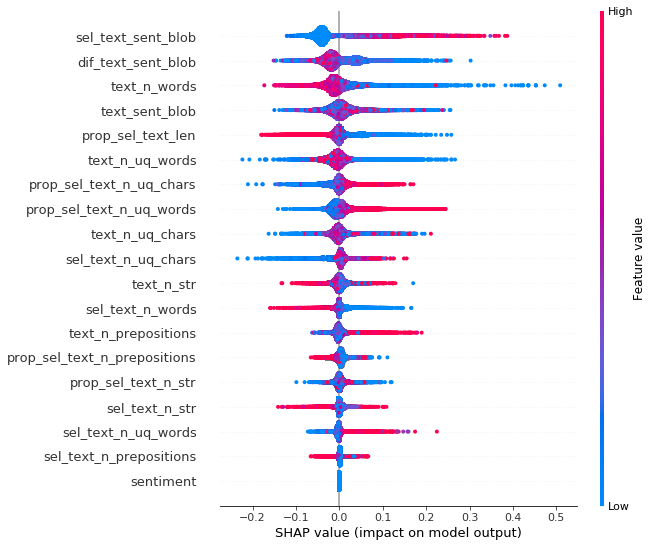

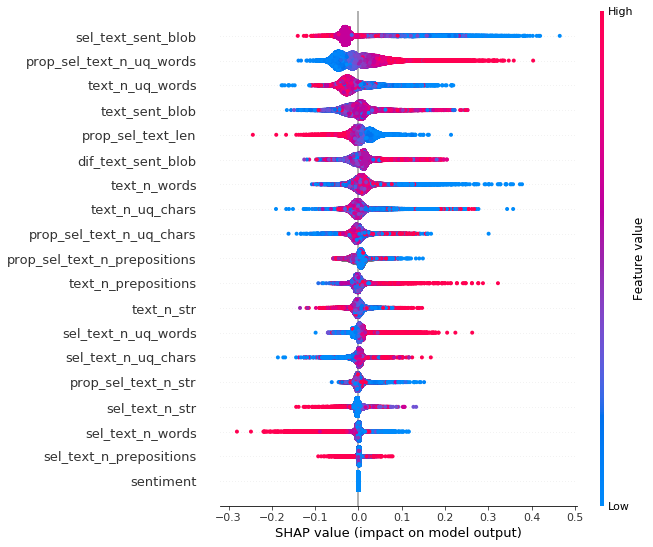

In [58]:
shap.summary_plot(shap_values_pos[:, :-1], test_pos[xgb_model_pos.feature_names])
shap.summary_plot(shap_values_neg[:, :-1], test_neg[xgb_model_neg.feature_names])

The upper image is for positive sentiment observations and the lower plot is for negative sentiment observations.

We can see features ngram blob sentiment score, blob sentiment score difference between ngram and selected text, and the portion of ngram text length against original text length are important for both categories.

Number of words in original text and blob sentiment score of original text are among top 5 important features for positive records; whereas number of unique words in orginal text and portion of number of unique words in ngram against original text are among top 5 important features for positive records.

We will take a closer look on how does each of the common top three important features impact on the prediction next.

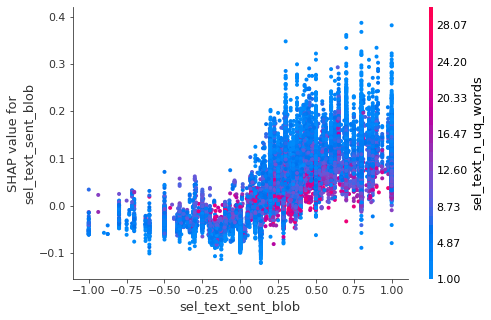

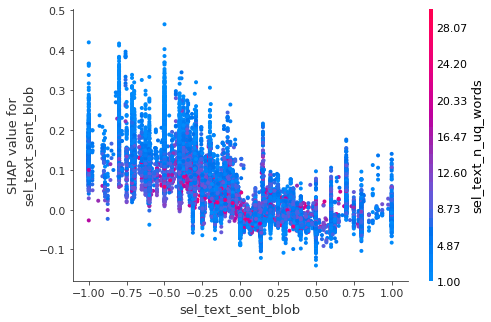

In [120]:
#Positive dataset
shap.dependence_plot('sel_text_sent_blob', shap_values_pos[:, :-1], test_pos[xgb_model_pos.feature_names],show=False)
#Negative dataset
shap.dependence_plot('sel_text_sent_blob', shap_values_neg[:, :-1], test_neg[xgb_model_neg.feature_names],show=False)

For postive sentiment records (upper image), when the original text's blob sentiment score goes up, the shapley value goes up whereas in negative dataset (lower image), the impact of the original text's blob sentiment score feature is the other way around. 

In both of the datasets, for original texts have the same blob sentiment score, the shapley value is also affected by the number of unique words in ngram. This is feature interactive effect.

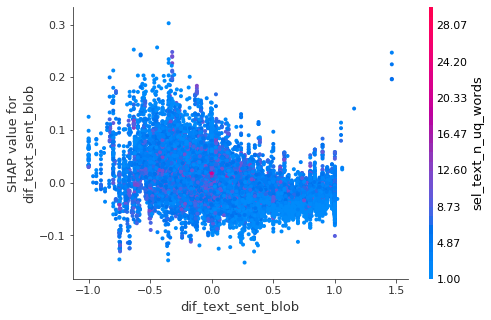

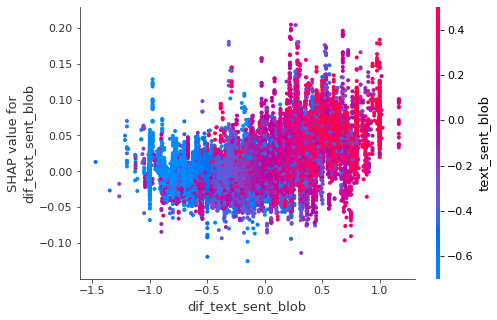

In [62]:
#Positive dataset
shap.dependence_plot('dif_text_sent_blob', shap_values_pos[:, :-1], test_pos[xgb_model_pos.feature_names],show=False)
#Negative dataset
shap.dependence_plot('dif_text_sent_blob', shap_values_neg[:, :-1], test_neg[xgb_model_neg.feature_names],show=False)

The difference blob sentiment score = sentiment score of original text - sentiment score of ngram. 

In the positive dataset(upper plot), when the difference gets larger and larger, the predicted jaccard score goes down- which means the similarity between ngram and selected texts gets lower. Whereas in negative dataset, when differece gets large, the predicted jaccard score goes up.

The feature that has interactive effect with difference blob sentiment score is different for these two categories.

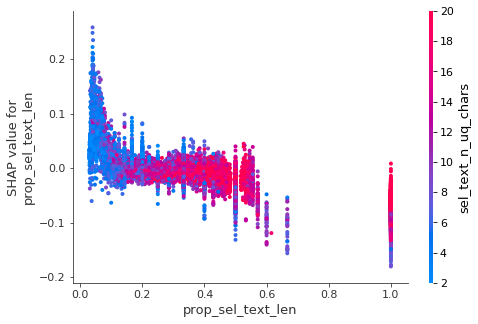

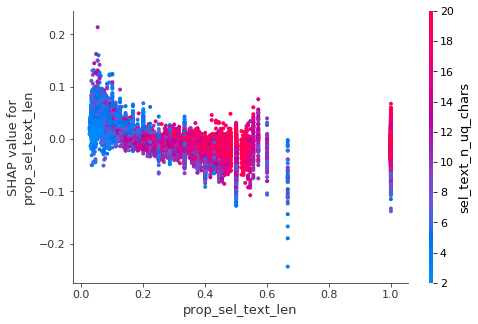

In [121]:
#Positive dataset
shap.dependence_plot('prop_sel_text_len', shap_values_pos[:, :-1], test_pos[xgb_model_pos.feature_names],show=False)
#Negative dataset
shap.dependence_plot('prop_sel_text_len', shap_values_neg[:, :-1], test_neg[xgb_model_neg.feature_names],show=False)

Prop_sel_text_len = Length of ngram / Length of original texts

This feature's impact on predicted jaccard score is similar for positive and negative sentiment records.

In [64]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe, ntree_limit=model.best_ntree_limit))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

In [66]:
#Positive dataset
par_sel_text_sent_blob_pos = par_dep('sel_text_sent_blob', test_pos[X], xgb_model_pos)
par_dif_text_sent_blob_pos = par_dep('dif_text_sent_blob', test_pos[X], xgb_model_pos)
par_text_n_words_pos = par_dep('text_n_words', test_pos[X], xgb_model_pos)
par_text_sent_blob_pos = par_dep('text_sent_blob', test_pos[X], xgb_model_pos)
par_prop_sel_text_len_pos = par_dep('prop_sel_text_len', test_pos[X], xgb_model_pos)

par_prop_sel_text_len_pos

,prop_sel_text_len,partial_dependence
0,0.030303,0.267151
1,0.078788,0.180124
2,0.127273,0.124562
3,0.175758,0.121263
4,0.224242,0.118276
5,0.272727,0.109076
6,0.321212,0.140977
7,0.369697,0.146498
8,0.418182,0.140067
9,0.466667,0.126582


In [67]:
#Negative dataset

par_sel_text_sent_blob_neg = par_dep('sel_text_sent_blob', test_neg[X], xgb_model_neg)
par_prop_sel_text_n_uq_words_neg = par_dep('prop_sel_text_n_uq_words', test_neg[X], xgb_model_neg)
par_text_n_uq_words_neg = par_dep('text_n_uq_words', test_neg[X], xgb_model_neg)
par_prop_sel_text_len_neg = par_dep('prop_sel_text_len', test_neg[X], xgb_model_neg)
par_dif_text_sent_blob_neg = par_dep('dif_text_sent_blob', test_neg[X], xgb_model_neg)

par_dif_text_sent_blob_neg

,dif_text_sent_blob,partial_dependence
0,-1.472656,0.183285
1,-1.340690,0.170945
2,-1.208724,0.170955
3,-1.076758,0.150091
4,-0.944792,0.144048
5,-0.812826,0.121547
6,-0.680859,0.135438
7,-0.548893,0.120757
8,-0.416927,0.121772
9,-0.284961,0.134351


In [68]:
def get_percentile_dict(yhat, id_, frame):

    """ Returns the percentiles of a column, yhat, as the indices based on 
        another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat, inplace=True)
    sort_df.reset_index(inplace=True)
    
    # find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    # find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict

In [70]:
# merge GBM predictions onto Positive test data
yhat_test_pos = pd.concat([test_pos.reset_index(drop=True), pd.DataFrame(xgb_model_pos.predict(dtest_pos,
                                                                                   ntree_limit=xgb_model_pos.best_ntree_limit))],
                      axis=1)
yhat_test_pos = yhat_test_pos.rename(columns={0:'p_jaccard'})

# find percentiles of predictions
percentile_dict_pos = get_percentile_dict('p_jaccard', 'ID', yhat_test_pos)

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
percentile_dict_pos

{0: 159646,
 99: 344058,
 10: 522439,
 20: 186700,
 30: 285466,
 40: 251757,
 50: 535485,
 60: 487509,
 70: 377952,
 80: 525867,
 90: 372190}

In [71]:
# merge GBM predictions onto Negative test data
yhat_test_neg = pd.concat([test_neg.reset_index(drop=True), pd.DataFrame(xgb_model_neg.predict(dtest_neg,
                                                                                   ntree_limit=xgb_model_neg.best_ntree_limit))],
                      axis=1)
yhat_test_neg = yhat_test_neg.rename(columns={0:'p_jaccard'})

# find percentiles of predictions
percentile_dict_neg = get_percentile_dict('p_jaccard', 'ID', yhat_test_neg)

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
percentile_dict_neg

{0: 526290,
 99: 544347,
 10: 17802,
 20: 522058,
 30: 301286,
 40: 481058,
 50: 298889,
 60: 400082,
 70: 161642,
 80: 432018,
 90: 217593}

In [72]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)

In [82]:
bins_sel_text_sent_blob_pos = list(par_sel_text_sent_blob_pos['sel_text_sent_blob'])
bins_dif_text_sent_blob_pos = list(par_dif_text_sent_blob_pos['dif_text_sent_blob'])
bins_text_n_words_pos = list(par_text_n_words_pos['text_n_words'])


for i in sorted(percentile_dict_pos.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves for prop_sel_text_n_uq_words across percentiles at bins_prop_sel_text_n_uq_words intervals
    par_sel_text_sent_blob_pos[col_name] = par_dep('sel_text_sent_blob', 
                                    test_pos[test_pos['ID'] == int(percentile_dict_pos[i])][X], 
                                    xgb_model_pos, 
                                    bins=bins_sel_text_sent_blob_pos)['partial_dependence']
    
    # ICE curves for dif_text_sent_blob across percentiles at bins_dif_text_sent_blob intervals
    par_dif_text_sent_blob_pos[col_name] = par_dep('dif_text_sent_blob', 
                                    test_pos[test_pos['ID'] == int(percentile_dict_pos[i])][X], 
                                    xgb_model_pos, 
                                    bins=bins_dif_text_sent_blob_pos)['partial_dependence']
    
    # ICE curves for prop_sel_text_len across percentiles at bins_prop_sel_text_len intervals
    par_text_n_words_pos[col_name] = par_dep('text_n_words', 
                                    test_pos[test_pos['ID'] == int(percentile_dict_pos[i])][X],  
                                    xgb_model_pos, 
                                    bins=bins_text_n_words_pos)['partial_dependence']    

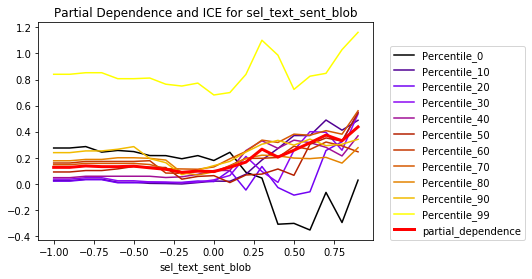

In [77]:
plot_par_dep_ICE('sel_text_sent_blob', par_sel_text_sent_blob_pos)

For positive model, the jaccard score is stable when average blob score for ngram is negative, and jaccard score gradually increases as average blob score become positive. Hence, the prediction of jaccard score could be higher for positive tweets.

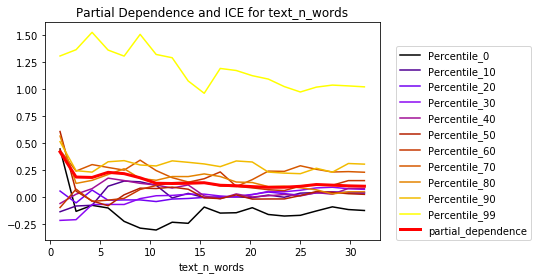

In [80]:
plot_par_dep_ICE('text_n_words', par_text_n_words_pos)

For positive model, the jaccard score has a significant decrease as number of words in original text increase from 1 to 2, then jaccard score decreases very slowly as the length of original text increases. The accuracy of predicting selected words is highest when word is a unigram, which is the word itself. And the accuracy gradually decreases as the original texts become longer and more complicated.

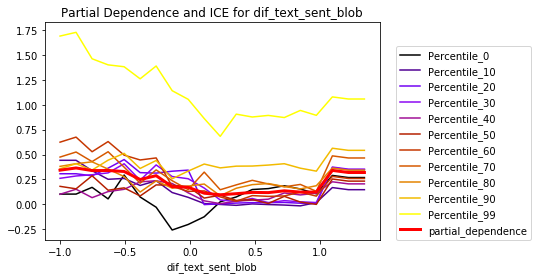

In [84]:
plot_par_dep_ICE('dif_text_sent_blob', par_dif_text_sent_blob_pos)

Dif_text_sent_blob = blob score for orignal text - blob score for ngram

In the positive model, the jaccard score slowly decreases as the average difference move from -1.0 to larger, and the jaccard score has a significant increase when the difference reaches 1.0. When difference = -1.0, the ngram score is more positive than original  text. When difference = 1.0 the original text is much more positive than ngram and the predicting accuracy is higher in this case.

In [83]:
bins_sel_text_sent_blob_neg = list(par_sel_text_sent_blob_neg['sel_text_sent_blob'])
bins_prop_sel_text_n_uq_words_neg = list(par_prop_sel_text_n_uq_words_neg['prop_sel_text_n_uq_words'])
bins_text_n_uq_words_neg = list(par_text_n_uq_words_neg['text_n_uq_words'])


for i in sorted(percentile_dict_neg.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves for prop_sel_text_n_uq_words across percentiles at bins_prop_sel_text_n_uq_words intervals
    par_sel_text_sent_blob_neg[col_name] = par_dep('sel_text_sent_blob', 
                                    test_neg[test_neg['ID'] == int(percentile_dict_neg[i])][X], 
                                    xgb_model_neg, 
                                    bins=bins_sel_text_sent_blob_neg)['partial_dependence']
    
    # ICE curves for dif_text_sent_blob across percentiles at bins_dif_text_sent_blob intervals
    par_prop_sel_text_n_uq_words_neg[col_name] = par_dep('prop_sel_text_n_uq_words', 
                                    test_neg[test_neg['ID'] == int(percentile_dict_neg[i])][X], 
                                    xgb_model_neg, 
                                    bins=bins_prop_sel_text_n_uq_words_neg)['partial_dependence']
    
    # ICE curves for prop_sel_text_len across percentiles at bins_prop_sel_text_len intervals
    par_text_n_uq_words_neg[col_name] = par_dep('text_n_uq_words', 
                                    test_neg[test_neg['ID'] == int(percentile_dict_neg[i])][X],  
                                    xgb_model_neg, 
                                    bins=bins_text_n_uq_words_neg)['partial_dependence']    


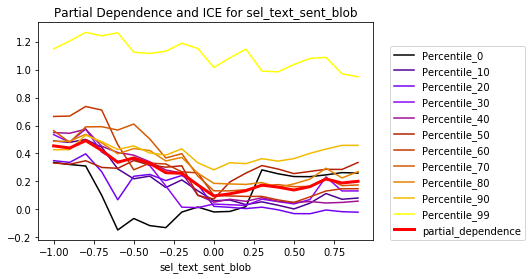

In [85]:
plot_par_dep_ICE('sel_text_sent_blob', par_sel_text_sent_blob_neg)

For negative model, the jaccard score first decline, then increase. When average ngram text sentiment blob is negative, the jaccard score decrease. When the average ngram text sentiment blob is positive, the jacquard score increase a little bit. This variable indicates another method of calculating sentiment score from textblob package, which have relationships with the jaccard score. The gram shows that when the twitter became more extreme, to -1 or to 1, it will have higher jaccard score

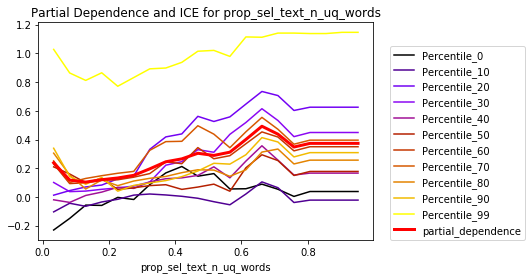

In [86]:
plot_par_dep_ICE('prop_sel_text_n_uq_words', par_prop_sel_text_n_uq_words_neg)

For a negative model, the Jaccard score is increasing when the average of the number of unique words in ngrams against the ones in texts increases. Then the Jaccard score decreases when the average of the number of unique words in ngrams against the ones in texts is between 0.65 and 0.75. After that, it becomes stable. Hence, the prediction of the Jaccard score could be higher for text with a high number of unique words in ngrams divided by the ones in texts.

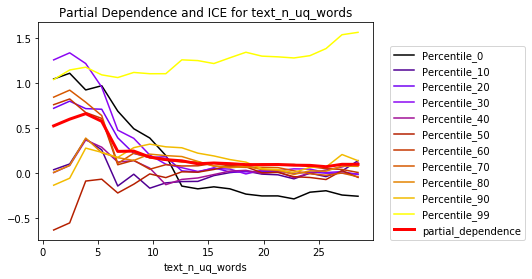

In [87]:
plot_par_dep_ICE('text_n_uq_words', par_text_n_uq_words_neg)

For negative model, the Jaccard score is increasing when the average number of unique words in the text is less than 4. Then the Jaccard score quickly decreases as the average number of unique words in the text increases up to 7. After that, it becomes stable. Hence, the prediction of Jaccard score could be higher for text with less words.

In [122]:
dtest_subsets_pos = xgb.DMatrix(test_subsets_pos[X])
dtest_subsets_neg = xgb.DMatrix(test_subsets_neg[X])

In [123]:
prediction_test_pos = xgb_model_pos.predict(dtest_subsets_pos)
prediction_test_neg = xgb_model_neg.predict(dtest_subsets_neg)

In [124]:
test_subsets_pos['Jaccard'] = prediction_test_pos
test_subsets_neg['Jaccard'] = prediction_test_neg

In [125]:
test_subsets_pos.head()

,textID,text,sentiment,text_n_words,text_sent_blob,text_n_str,text_n_uq_words,text_n_uq_chars,text_n_prepositions,ngram,sel_text_n_words,prop_sel_text_len,sel_text_sent_blob,dif_text_sent_blob,sel_text_n_str,prop_sel_text_n_str,sel_text_n_uq_words,prop_sel_text_n_uq_words,sel_text_n_uq_chars,prop_sel_text_n_uq_chars,sel_text_n_prepositions,prop_sel_text_n_prepositions,ID,Jaccard
0,96d74cb729,Shanghai is also really exciting (precisely -...,1,18,0.1625,3,15,29,1,Shanghai,1,0.055556,0.0,0.1625,1,0.333333,1,0.066667,6,0.206897,0,0.0,1,0.016607
1,96d74cb729,Shanghai is also really exciting (precisely -...,1,18,0.1625,3,15,29,1,Shanghai is,2,0.111111,0.0,0.1625,1,0.333333,2,0.133333,7,0.241379,0,0.0,2,0.035116
2,96d74cb729,Shanghai is also really exciting (precisely -...,1,18,0.1625,3,15,29,1,Shanghai is also,3,0.166667,0.0,0.1625,1,0.333333,3,0.200000,9,0.310345,0,0.0,3,0.043508
3,96d74cb729,Shanghai is also really exciting (precisely -...,1,18,0.1625,3,15,29,1,Shanghai is also really,4,0.222222,0.2,-0.0375,1,0.333333,4,0.266667,12,0.413793,0,0.0,4,0.174192
4,96d74cb729,Shanghai is also really exciting (precisely -...,1,18,0.1625,3,15,29,1,Shanghai is also really exciting,5,0.277778,0.3,-0.1375,1,0.333333,5,0.333333,15,0.517241,0,0.0,5,0.206217


In [126]:
test_subsets_neg.head()

,textID,text,sentiment,text_n_words,text_sent_blob,text_n_str,text_n_uq_words,text_n_uq_chars,text_n_prepositions,ngram,sel_text_n_words,prop_sel_text_len,sel_text_sent_blob,dif_text_sent_blob,sel_text_n_str,prop_sel_text_n_str,sel_text_n_uq_words,prop_sel_text_n_uq_words,sel_text_n_uq_chars,prop_sel_text_n_uq_chars,sel_text_n_prepositions,prop_sel_text_n_prepositions,ID,Jaccard
36,eee518ae67,"Recession hit Veronique Branquinho, she has to...",0,13,0.0,4,13,20,1,Recession,1,0.076923,0.0,0.0,1,0.25,1,0.076923,7,0.35,0,0.0,37,0.132402
37,eee518ae67,"Recession hit Veronique Branquinho, she has to...",0,13,0.0,4,13,20,1,Recession hit,2,0.153846,0.0,0.0,1,0.25,2,0.153846,9,0.45,0,0.0,38,0.081442
38,eee518ae67,"Recession hit Veronique Branquinho, she has to...",0,13,0.0,4,13,20,1,Recession hit Veronique,3,0.230769,0.0,0.0,1,0.25,3,0.230769,13,0.65,0,0.0,39,0.072952
39,eee518ae67,"Recession hit Veronique Branquinho, she has to...",0,13,0.0,4,13,20,1,"Recession hit Veronique Branquinho,",4,0.307692,0.0,0.0,2,0.50,4,0.307692,16,0.80,0,0.0,40,0.151464
40,eee518ae67,"Recession hit Veronique Branquinho, she has to...",0,13,0.0,4,13,20,1,"Recession hit Veronique Branquinho, she",5,0.384615,0.0,0.0,2,0.50,5,0.384615,16,0.80,0,0.0,41,0.173257


In [127]:
test_submission_pos = test_subsets_pos.sort_values('Jaccard', ascending=False).drop_duplicates(['textID'])
test_submission_neg = test_subsets_neg.sort_values('Jaccard', ascending=False).drop_duplicates(['textID'])

In [128]:
test_submission_pos = test_submission_pos[['textID','ngram']]
test_submission_neg = test_submission_neg[['textID','ngram']]
test_submission_pos = test_submission_pos.rename(columns = {'ngram':'selected_text'})
test_submission_neg = test_submission_neg.rename(columns = {'ngram':'selected_text'})
test_submission = test_submission_pos.append(test_submission_neg)
neutral_submission = neutral_test[['textID','text']]
neutral_submission = neutral_submission.rename(columns = {'text':'selected_text'})
submission = test_submission.append(neutral_submission,ignore_index=True)
sample_submission = sample_submission.drop(columns=['selected_text'])
sample_submission = pd.merge(sample_submission,submission,on='textID',how='left')

In [129]:
sample_submission.to_csv('submission.csv', index = False)